# POS-Tagging zum identifizieren von Narrativen

In [43]:
import spacy
from spacy_layout import spaCyLayout
from pipeline_merge_pdf import process_pdf_folder
import os
import time

#Ordner, in dem PDFs liegen
pdf_folder = "../data/DSA/Der_blaue_Bruder"
merged_pdf_path = os.path.join(pdf_folder, "_combined.pdf")

#Prüfen ob eine merged-Datei bereits vorhanden ist. Falls nicht, diese erzeugen
if os.path.exists(merged_pdf_path):
    print("Die Datei _combined.pdf existiert bereits unter folgendem Pfad:",merged_pdf_path)
    print("Lade die Datei lokal..\n")
    time.sleep(0.5)
    nlp = spacy.blank("de")
    layout = spaCyLayout(nlp)
    doc = layout(merged_pdf_path)
else:
    print("Die Datei _combined.pdf existiert noch nicht. Merge-Pipeline wird durchgeführt..")
    #Pipeline ausführen
    doc = process_pdf_folder(pdf_folder)

#spaCy-Doc
print("\nAnzahl Layout-Spans:", len(doc.spans["layout"]))


Die Datei _combined.pdf existiert bereits unter folgendem Pfad: ../data/DSA/Der_blaue_Bruder/_combined.pdf
Lade die Datei lokal..



2025-12-17 18:30:12,647 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-12-17 18:30:12,671 - INFO - Going to convert document batch...
2025-12-17 18:30:12,672 - INFO - Initializing pipeline for StandardPdfPipeline with options hash f9730ffaa6e7f8d4fb0c98c8df3f18cb
2025-12-17 18:30:12,673 - INFO - rapidocr cannot be used because onnxruntime is not installed.
2025-12-17 18:30:12,675 - INFO - easyocr cannot be used because it is not installed.
2025-12-17 18:30:12,676 - INFO - Accelerator device: 'cuda:0'
[INFO] 2025-12-17 18:30:12,683 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-12-17 18:30:12,688 [RapidOCR] download_file.py:60: File exists and is valid: /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-12-17 18:30:12,688 [RapidOCR] torch.py:54: Using /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO


Anzahl Layout-Spans: 1833


In [44]:
from pipeline_preproc_pdf import process_doc_into_posts #aktell mit filter für direkte Sprache

# 2) Posts extrahieren + bereinigen
posts = process_doc_into_posts(doc)

# 3) ausgeben
for i, p in enumerate(posts):
    print(f"--- Post {i+1} ---\n{p}\n")

--- Post 1 ---
Die Grafschaft Heldentrutz zwischen Finsterkamm und Finsterbach ist eine der ärmsten und wildesten Regionen Weidens. Sie wird von zahlreichen dichten und gefährlichen Wäldern, mit Harpyien, Orks und Drachen, urwüchsigen Wiesen sowie von Heide- und Moorlandschaften geprägt. Neben ein wenig Kornwirtschaft betreiben die Leute vor allem Kohl- und Rübenanbau, sowie Viehwirtschaft, vor allem Schafe und Ziegen. Einzige  Ausnahme  in der ganzen Ärmlichkeit ist die Baronie Nordhag mit der gleichnamigen Stadt, die durch die dort vorhandenen Salzvorkommen zu Reichtum gekommen  ist.  Nordhag bildet das wirtschaftliche und kulturelle Zentrum der Grafschaft, liegt an wichtigen Handelswegen (Norrnstieg, Alter Weg,  Alte Straße), richtet zweimal  im Jahr den großen Wollmarkt aus und ist durch die Feste Norrbrug ganz gut geschützt. Am 10. Efferd des Jahres 1040 BF, zur Zeit des zweiten Wollmarktes leben in Nordhag um  die 900 Einwohner, man  findet dort Tempel  von Rondra, Phex, Peraine 

In [108]:
from rapidfuzz import fuzz
from nltk.tokenize import word_tokenize
from pathlib import Path

testtext = "Heldenstrutz"

sentences = word_tokenize(posts[0])
print(sentences)



for txt_file in Path("/home/timc/Workspace/nlp-rpg-narratives/").glob("*.txt"):
    with open(txt_file, "r", encoding="utf-8") as f:
        names = [line.strip() for line in f if line.strip()]
        for name in names:
            for sent in sentences:
                erg = fuzz.ratio(sent, name)
                if erg > 90.0:
                    print("Score:",erg,"-->",sent,"(",name,")")


print("-------------------------------------------------------------------------------------------")

f = open("dsa_names.txt")
namensliste = f.read()
namensliste_split = namensliste.split("\n")
print(namensliste_split[6665:9999])

for name in namensliste_split:
    for sent in sentences:
        erg = fuzz.ratio(sent, name)
        if erg > 90.0:
            print("Score:",erg,"-->",sent,"(",name,")")

#fuzz.ratio(sentences[0], "Praiodane")



['Die', 'Grafschaft', 'Heldentrutz', 'zwischen', 'Finsterkamm', 'und', 'Finsterbach', 'ist', 'eine', 'der', 'ärmsten', 'und', 'wildesten', 'Regionen', 'Weidens', '.', 'Sie', 'wird', 'von', 'zahlreichen', 'dichten', 'und', 'gefährlichen', 'Wäldern', ',', 'mit', 'Harpyien', ',', 'Orks', 'und', 'Drachen', ',', 'urwüchsigen', 'Wiesen', 'sowie', 'von', 'Heide-', 'und', 'Moorlandschaften', 'geprägt', '.', 'Neben', 'ein', 'wenig', 'Kornwirtschaft', 'betreiben', 'die', 'Leute', 'vor', 'allem', 'Kohl-', 'und', 'Rübenanbau', ',', 'sowie', 'Viehwirtschaft', ',', 'vor', 'allem', 'Schafe', 'und', 'Ziegen', '.', 'Einzige', 'Ausnahme', 'in', 'der', 'ganzen', 'Ärmlichkeit', 'ist', 'die', 'Baronie', 'Nordhag', 'mit', 'der', 'gleichnamigen', 'Stadt', ',', 'die', 'durch', 'die', 'dort', 'vorhandenen', 'Salzvorkommen', 'zu', 'Reichtum', 'gekommen', 'ist', '.', 'Nordhag', 'bildet', 'das', 'wirtschaftliche', 'und', 'kulturelle', 'Zentrum', 'der', 'Grafschaft', ',', 'liegt', 'an', 'wichtigen', 'Handelswegen'

In [39]:
from rapidfuzz import fuzz
from pathlib import Path
import re

# -----------------------------------
# Beispiel-Posts
# -----------------------------------
posts = [
    "Elan Mask met Angela Merkl at Apple headquarters",
    "Barack Obamma talked about Microsoft and Google",
    "Random unrelated text"
]

# -----------------------------------
# Namenslisten laden
# -----------------------------------
def load_name_lists(folder_path: str) -> dict:
    name_lists = {}

    for txt_file in Path(folder_path).glob("*.txt"):
        with open(txt_file, "r", encoding="utf-8") as f:
            names = [line.strip() for line in f if line.strip()]
            name_lists[txt_file.stem] = names  # stem = filename ohne .txt

    return name_lists


# -----------------------------------
# Fuzzy Matching + Pseudonymisierung
# -----------------------------------
def fuzzy_match_and_pseudonymize(posts, name_lists, threshold=80):
    results = []

    for post in posts:
        pseudonymized_post = post
        post_matches = []

        for list_name, names in name_lists.items():
            placeholder = f"<{list_name.upper()}>"

            for name in names:
                score = fuzz.partial_ratio(post.lower(), name.lower())

                if score >= threshold:
                    post_matches.append({
                        "original_name": name,
                        "list": list_name,
                        "score": score
                    })

                    # 🔒 Pseudonymisierung (robust, case-insensitive)
                    pattern = re.compile(re.escape(name), re.IGNORECASE)
                    pseudonymized_post = pattern.sub(placeholder, pseudonymized_post)

        results.append({
            "original_post": post,
            "pseudonymized_post": pseudonymized_post,
            "matches": post_matches
        })

    return results


# -----------------------------------
# Ausführung
# -----------------------------------
name_lists = load_name_lists("names")
results = fuzzy_match_and_pseudonymize(posts, name_lists, threshold=80)

# -----------------------------------
# Ausgabe
# -----------------------------------
for r in results:
    print("\nORIGINAL:       ", r["original_post"])
    print("PSEUDONYMISIERT:", r["pseudonymized_post"])
    print("MATCHES:")
    for m in r["matches"]:
        print(
            f"  - {m['original_name']} "
            f"(Liste: {m['list']}, Score: {m['score']})"
        )



ORIGINAL:        Elan Mask met Angela Merkl at Apple headquarters
PSEUDONYMISIERT: Elan Mask met Angela Merkl at Apple headquarters
MATCHES:

ORIGINAL:        Barack Obamma talked about Microsoft and Google
PSEUDONYMISIERT: Barack Obamma talked about Microsoft and Google
MATCHES:

ORIGINAL:        Random unrelated text
PSEUDONYMISIERT: Random unrelated text
MATCHES:


In [4]:
from pipeline_preproc_lemma import TextPreprocessingPipeline #Posts von Satzzeichen und Ziffern bereinigen & anschließend lemmatisieren 

pipeline = TextPreprocessingPipeline()
posts = pipeline.process_posts(posts, debug=False) #debug für print-Ausgaben der Zwischenschritte

#Posts ausgeben
for i, p in enumerate(posts):
    print(f"--- Post {i+1} ---\n{p}\n")

Lade spaCy-Modell ...
--- Post 1 ---
der grafschaft heldentrutz zwischen finsterkamm und finsterbach sein einer der arm und wilde region weidens sie werden von zahlreich dicht und gefährlich wäldern mit harpyi orks und drach urwüchsigen weisen sowie von heide und moorlandschaft prägen neben ein wenig kornwirtschaft betreiben der leute vor alle kohl und rübenanbau sowie viehwirtschaft vor alle schaf und ziegen einzig ausnahme in der ganz ärmlichkeit sein der baronie nordhag mit der gleichnamig stadt der durch der dort vorhanden salzvorkomme zu reichtum kommen sein nordhag bilden der wirtschaftlich und kulturell zentrum der grafschaft liegen an wichtig handelsweg norrnstieg alt weg alt straße richten zweimal in jahr der groß wollmarkt aus und sein durch der fest norrbrug ganz gut schützen an 10 efferd der jahr bf zu zeit der zweiter wollmarkt leben in nordhag um der einwohner man finden dort tempel von rondra phex peraine und ingerimm sowie diverser gasthäuser und tavernen der markt und 

In [5]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("de_core_news_lg")

reise_patterns = [
    # wanderte, wanderten, wanderst, wandert, etc.
    [{"LOWER": {"REGEX": "^wander"} , "POS": "VERB"}],

    # Lemma: reisen, ziehen, marschieren, durchqueren
    [{"LEMMA": {"IN": ["erreichen","reisen","ziehen","marschieren","durchqueren"]}, "POS": "VERB"}],

    # trennbares aufbrechen → brach ... auf
    [{"LEMMA": "brechen", "POS": "VERB"}, {"LOWER": "auf"}],

    # Nomen
    [{"LEMMA": {"IN": ["reise","weg","pfad","expedition","marsch"]}, "POS": "NOUN"}],
]

kampf_patterns = [
    [{"LEMMA": {"IN": ["kämpfen","angreifen","verteidigen","zuschlagen","stechen"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["kampf","angriff","duell","schlacht","gegner","feind"]}, "POS": "NOUN"}]
]

ausruhen_patterns = [
    # ruhten
    [{"LEMMA": {"IN": ["ruhen","rasten","schlafen","lagern","entspannen"]}, "POS": "VERB"}],
    
    # ruhten ... aus  (trennbar!)
    [{"LEMMA": "ruhen"}, {"LOWER": "aus"}],

    # Nomen
    [{"LEMMA": {"IN": ["rast","pause","lager","ruhe","erholung"]}, "POS": "NOUN"}]
]

rettung_patterns = [
    [{"LEMMA": {"IN": ["retten","befreien","beschützen","opfern"]}, "POS": "VERB"}],
    [{"LOWER": {"IN": ["rettung","hilferuf","opfer","heldentat","gefahr","bedrohung"]}, "POS": "NOUN"}]
]

flucht_patterns = [
    # fliehen, entkommen, flüchten
    [{"LEMMA": {"IN": ["fliehen","entkommen","flüchten","verstecken"]}, "POS": "VERB"}],

    # trennbares wegrennen / rannte ... weg
    [{"LEMMA": "rennen", "POS": "VERB"}, {"LOWER": "weg"}],
    [{"LOWER": "weg"}, {"LEMMA": "rennen"}],

    [{"LEMMA": {"IN": ["flucht","unterschlupf","versteck","panik"]}, "POS": "NOUN"}]
]

training_patterns = [
    [{"LEMMA": {"IN": ["trainieren","üben","vorbereiten","meditieren"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["training","übung","vorbereitung","lektion","technik"]}, "POS": "NOUN"}]
]

verfolgung_patterns = [
    [{"LEMMA": {"IN": ["verfolgen","jagen","suchen"]}, "POS": "VERB"}],
    [{"LEMMA": "spüren", "POS": "VERB"}, {"LOWER": "auf"}],
    [{"LEMMA": {"IN": ["verfolgung","jagd","spur","fährte"]}, "POS": "NOUN"}]
]

ruf_patterns = [
    [{"LEMMA": {"IN": ["rufen","einladen","beauftragen","verkünden","offenbaren"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["ruf","auftrag","prophezeiung","vision","botschaft"]}, "POS": "NOUN"}]
]
belohnung_patterns = [
    [{"LEMMA": {"IN": ["belohnen","erkennen","verstehen","entdecken","gewinnen"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["belohnung","schatz","erkenntnis","wahrheit","einsicht"]}, "POS": "NOUN"}]
]

categories = {
    "Reise": reise_patterns,
    "Kampf": kampf_patterns,
    "Ausruhen": ausruhen_patterns,
    "Rettung": rettung_patterns,
    "Flucht": flucht_patterns,
    "Training": training_patterns,
    "Verfolgung": verfolgung_patterns,
    "Ruf": ruf_patterns,
    "Belohnung": belohnung_patterns
}

# Matcher erstellen
matcher = Matcher(nlp.vocab)

# Patterns dem Matcher hinzufügen
for label, patterns in categories.items():
    matcher.add(label, patterns)

for post in posts:
    doc = nlp(post)
    matches = matcher(doc)
    #print(matches)

    # Ergebniscontainer
    category_hits = {c: [] for c in categories}

    # Treffer zuordnen
    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]
        span = doc[start:end]
        category_hits[label].append(span.text)

    # Ausgabe
    for cat, hits in category_hits.items():
        if hits:
            print(f"{cat}: {hits}")


Reise: ['ziehen', 'erreichen']
Verfolgung: ['verfolgen']
Verfolgung: ['suchen', 'suchen']
Belohnung: ['verstehen', 'erkennen']
Ausruhen: ['entspannen']
Verfolgung: ['suchen']
Reise: ['erreichen']
Reise: ['erreichen']
Reise: ['reisen']
Ausruhen: ['entspannen']
Ruf: ['rufen']
Belohnung: ['verstehen']
Belohnung: ['verstehen']
Ausruhen: ['ruhen']
Belohnung: ['verstehen']
Reise: ['ziehen']
Reise: ['ziehen', 'erreichen']
Reise: ['erreichen', 'erreichen']
Rettung: ['befreien']
Verfolgung: ['suchen']
Training: ['vorbereiten']
Belohnung: ['erkennen']
Belohnung: ['entdecken', 'erkennen', 'erkennen']
Flucht: ['fliehen']
Reise: ['reisen']
Belohnung: ['entdecken']
Verfolgung: ['suchen']
Verfolgung: ['suchen', 'suchen']
Belohnung: ['entdecken', 'erkennen']
Ruf: ['verkünden']
Belohnung: ['verstehen', 'erkennen']
Verfolgung: ['suchen']
Reise: ['ziehen']
Belohnung: ['erkennen']
Verfolgung: ['suchen']
Ruf: ['verkünden']
Belohnung: ['verstehen']
Reise: ['ziehen']
Reise: ['ziehen']
Reise: ['wandern']
Verf

### Selber Code, jedoch mit NLTK Analyse dabei

In [6]:
import nltk
from nltk.text import Text
from nltk.tokenize import word_tokenize
from nltk.text import ConcordanceIndex
import io
import sys
from collections import defaultdict

# sicherstellen dass benötigte NLTK-Ressourcen vorhanden sind
nltk.download('punkt')
nltk.download('stopwords')

def kwic_from_tokens(tokens, target, window=5):
    target = target.lower()
    kwics = []
    
    for i, tok in enumerate(tokens):
        
        if tok.lower() == target:
            left = tokens[max(0, i-window):i]
            right = tokens[i+1:i+1+window]

            kwics.append({
                "left": " ".join(left),
                "node": tok,
                "right": " ".join(right)
            })

    return kwics

kwic_by_category = defaultdict(list)
concord_by_category = defaultdict(list)
concord_list = []

for post in posts:
    print("\n==============================")
    print("TEXT:")
    print(post)
    print("==============================\n")

    # ---- spaCy Matching ----
    doc = nlp(post)
    matches = matcher(doc)

    category_hits = {c: [] for c in categories}

    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]
        span = doc[start:end]
        category_hits[label].append(span.text)

    # Ergebnisse anzeigen
    print("SPACY-KATEGORIEN:")
    for cat, hits in category_hits.items():
        if hits:
            print(f"{cat}: {hits}")

    # ---- NLTK Analyse ----
    print("\n----- NLTK-ANALYSE -----")

    tokens = word_tokenize(post)
    nltk_text = Text(tokens)

    # 1. Collocations (Wortpaare)
    print("\nCollocations:")
    nltk_text.collocations()

    # 2. Häufigste Wörter (ohne Stoppwörter)
    from nltk.corpus import stopwords
    stops = set(stopwords.words("german"))

    freq = nltk.FreqDist([t.lower() for t in tokens if t.lower() not in stops])
    print("\nHäufigste Wörter:")
    print(freq.most_common(10))

    # 3. Concordance pro gefundenem Schlüsselwort:

    #Nur generelle Ausgabe von concordance, ohne Weiterverarbeitung
    print("\nConcordance pro Kategorie-Treffer:")
    """for cat, hits in category_hits.items():
        for word in hits:
            w = word.lower()
            print(f"\n--- Concordance für '{w}' ({cat}) ---")
            try:
                nltk_text.concordance(w, width=120)
                nltk_text.concordance(w, width=20)
            except:
                print("(keine Treffer im NLTK-Tokenizing)")"""

# ---------------------------------------------------------------------------------------------------    
    #hiermit bekommen wir alle Concordance-Ergebnisse nach Kategorien sortiert. Aber immer als zusammenhängender String
    """for cat, hits in category_hits.items():
        for word in hits:
            w = word.lower()
            print(f"\n--- Concordance für '{w}' ({cat}) ---")

            try:
                # --- erste Concordance: width=120 -------------------------
                buffer1 = io.StringIO()
                original_stdout = sys.stdout

                try:
                    sys.stdout = buffer1
                    nltk_text.concordance(w) #width=120
                finally:
                    sys.stdout = original_stdout

                output1 = buffer1.getvalue()
                buffer1.close()
                lines_width120 = output1.strip().split("\n")

                # Beispielausgabe (du kannst hier machen was du willst)
                print("Treffer (width=120):", len(lines_width120))
                concord_by_category[cat].extend(lines_width120[1:])

            except Exception as e:
                print("(keine Treffer im NLTK-Tokenizing)")"""

    # ---------------------------------------------------------------------------------------------------    

    #Direkte Verarbeitung von Concordance in "left", "node" und "right". Das ganze in einem Dict mit Schlüssen aus category
    for cat, hits in category_hits.items():
        for word in hits:
            w = word.lower()

            kwics = kwic_from_tokens(tokens, w, window=6)
            for k in kwics:
                k["category"] = cat
                kwic_by_category[cat].append(k)

    print("\n#############################################################")
    print("##################### Post Ende #############################")
    print("#############################################################")


[nltk_data] Downloading package punkt to /home/timc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/timc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



TEXT:
der grafschaft heldentrutz zwischen finsterkamm und finsterbach sein einer der arm und wilde region weidens sie werden von zahlreich dicht und gefährlich wäldern mit harpyi orks und drach urwüchsigen weisen sowie von heide und moorlandschaft prägen neben ein wenig kornwirtschaft betreiben der leute vor alle kohl und rübenanbau sowie viehwirtschaft vor alle schaf und ziegen einzig ausnahme in der ganz ärmlichkeit sein der baronie nordhag mit der gleichnamig stadt der durch der dort vorhanden salzvorkomme zu reichtum kommen sein nordhag bilden der wirtschaftlich und kulturell zentrum der grafschaft liegen an wichtig handelsweg norrnstieg alt weg alt straße richten zweimal in jahr der groß wollmarkt aus und sein durch der fest norrbrug ganz gut schützen an 10 efferd der jahr bf zu zeit der zweiter wollmarkt leben in nordhag um der einwohner man finden dort tempel von rondra phex peraine und ingerimm sowie diverser gasthäuser und tavernen der markt und der salzhandel ziehen zu diese

In [7]:
kwic_by_category["Reise"][1]


{'left': 'sie vor einiger zeit in festum',
 'node': 'erreichen',
 'right': 'wenn sie denn mal in der',
 'category': 'Reise'}

In [8]:
kwic_by_category["Reise"]


[{'left': 'tavernen der markt und der salzhandel',
  'node': 'ziehen',
  'right': 'zu dieser zeit viel fremd volk',
  'category': 'Reise'},
 {'left': 'sie vor einiger zeit in festum',
  'node': 'erreichen',
  'right': 'wenn sie denn mal in der',
  'category': 'Reise'},
 {'left': 'zu rahjastunde',
  'node': 'erreichen',
  'right': 'praiodane der norrburg oberhalb der stadt',
  'category': 'Reise'},
 {'left': 'er von hier aus der phextempel',
  'node': 'erreichen',
  'right': 'können',
  'category': 'Reise'},
 {'left': 'sein ihr aus der tulamidenlande hierher',
  'node': 'reisen',
  'right': 'ich haben sich noch nie als',
  'category': 'Reise'},
 {'left': 'auch praiodane',
  'node': 'ziehen',
  'right': 'bei der verhalten kurz der augenbraue',
  'category': 'Reise'},
 {'left': 'nicht allzu viel aufregend der weg',
  'node': 'ziehen',
  'right': 'sich auch wenn ihr zu pferd',
  'category': 'Reise'},
 {'left': 'olat und nach ein paar tag',
  'node': 'erreichen',
  'right': 'ihr dann reichs

In [9]:
new_string = kwic_by_category["Reise"][1]["left"] + kwic_by_category["Reise"][1]["node"] + kwic_by_category["Reise"][1]["right"]
new_string

'sie vor einiger zeit in festumerreichenwenn sie denn mal in der'

In [10]:
texte_reise = []

for i in kwic_by_category["Reise"]:
    new_string = i["left"] + " " + i["node"] + " " + i["right"]
    texte_reise.append(new_string)

print(texte_reise[7])
print(texte_reise[9])

olat und nach ein paar tag erreichen ihr dann reichsend
gefährt an bevor sie der stadttor erreichen bis auf sein kurzschweren sein kein


In [11]:
texte_ausruhen = []

for i in kwic_by_category["Ausruhen"]:
    new_string = i["left"] + " " + i["node"] + " " + i["right"]
    texte_ausruhen.append(new_string)

print(texte_ausruhen[1])
print(texte_ausruhen[2])

meinen praiodane entspannen der tittel gräfin versprechen mehr als
blick hilgerts etwas lang auf ihm ruhen fügen er an


In [12]:
texte_verfolgung = []

for i in kwic_by_category["Verfolgung"]:
    new_string = i["left"] + " " + i["node"] + " " + i["right"]
    texte_verfolgung.append(new_string)

print(texte_verfolgung[1])
print(texte_verfolgung[2])

und sich dann ein frei tisch suchen um etwas zu essen dabei werden
hören wer vielleicht jemand zu reiseunterstützung suchen 


In [13]:
# Installation (falls noch nicht installiert)
# pip install sentence-transformers

from sentence_transformers import SentenceTransformer, util

# Modell laden (z.B. 'all-MiniLM-L6-v2' ist klein & schnell)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Texte in Embeddings umwandeln
embeddings = model.encode(texte_verfolgung, convert_to_tensor=True)

# Kosinus-Ähnlichkeiten berechnen
cosine_sim = util.cos_sim(embeddings, embeddings)

# Ähnlichkeiten ausgeben
print("Kosinus-Ähnlichkeitsmatrix (semantisch):")
print(cosine_sim)

# Optional: ähnlichste Paare finden
num_texts = len(texte_verfolgung)
for i in range(num_texts):
    for j in range(i+1, num_texts):
        print(f"Ähnlichkeit zwischen Text {i} und Text {j}: {cosine_sim[i][j]:.2f}")


2025-12-17 15:39:21,049 - INFO - Use pytorch device_name: cuda:0
2025-12-17 15:39:21,050 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

Kosinus-Ähnlichkeitsmatrix (semantisch):
tensor([[1.0000, 0.2441, 0.2498, 0.2441, 0.2498, 0.3797, 0.2049, 0.3455, 0.2764,
         0.3476, 0.2764, 0.3476, 0.2603, 0.3055, 0.2634, 0.2634, 0.4296, 0.2915,
         0.2870, 0.3703, 0.3790],
        [0.2441, 1.0000, 0.4337, 1.0000, 0.4337, 0.3388, 0.3145, 0.4842, 0.4784,
         0.3344, 0.4784, 0.3344, 0.5738, 0.3655, 0.4915, 0.2970, 0.4172, 0.3239,
         0.2832, 0.4141, 0.4302],
        [0.2498, 0.4337, 1.0000, 0.4337, 1.0000, 0.4638, 0.2524, 0.3261, 0.3472,
         0.3434, 0.3472, 0.3434, 0.4007, 0.3479, 0.4337, 0.2925, 0.3189, 0.3672,
         0.2433, 0.4328, 0.3899],
        [0.2441, 1.0000, 0.4337, 1.0000, 0.4337, 0.3388, 0.3145, 0.4842, 0.4784,
         0.3344, 0.4784, 0.3344, 0.5738, 0.3655, 0.4915, 0.2970, 0.4172, 0.3239,
         0.2832, 0.4141, 0.4302],
        [0.2498, 0.4337, 1.0000, 0.4337, 1.0000, 0.4638, 0.2524, 0.3261, 0.3472,
         0.3434, 0.3472, 0.3434, 0.4007, 0.3479, 0.4337, 0.2925, 0.3189, 0.3672,
         0.24

2025-12-17 15:39:23,389 - INFO - Use pytorch device_name: cuda:0
2025-12-17 15:39:23,391 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 1/1 [00:00<00:00, 112.89it/s]
/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster-Ergebnisse:

Cluster -1:
 - aufspürt und bis kurz vor nordhag verfolgen wo sich der spur in gewimmel
 - und sich dann ein frei tisch suchen um etwas zu essen dabei werden
 - hören wer vielleicht jemand zu reiseunterstützung suchen 
 - und sich dann ein frei tisch suchen um etwas zu essen dabei werden
 - hören wer vielleicht jemand zu reiseunterstützung suchen 
 - ein leicht räuspern gehör zu verschaffen suchen 
 - er schauen sich in schankraum um suchen der schankwirt oder ein bedienstet um
 - sicher sein und alle wo anders suchen dieser an sich zu nehmen etwa
 - inhalt durch und scheinen etwas zu suchen alle da aber was für ein
 - gürteltasch da finden sich was er suchen ein paar einfach klein stoffstück aus
 - inhalt durch und scheinen etwas zu suchen alle da aber was für ein
 - gürteltasch da finden sich was er suchen ein paar einfach klein stoffstück aus
 - muss ein klein wenig nachdenken dann suchen er auf sein tisch nach ein
 - surka lächeln walburia dankend an und suchen

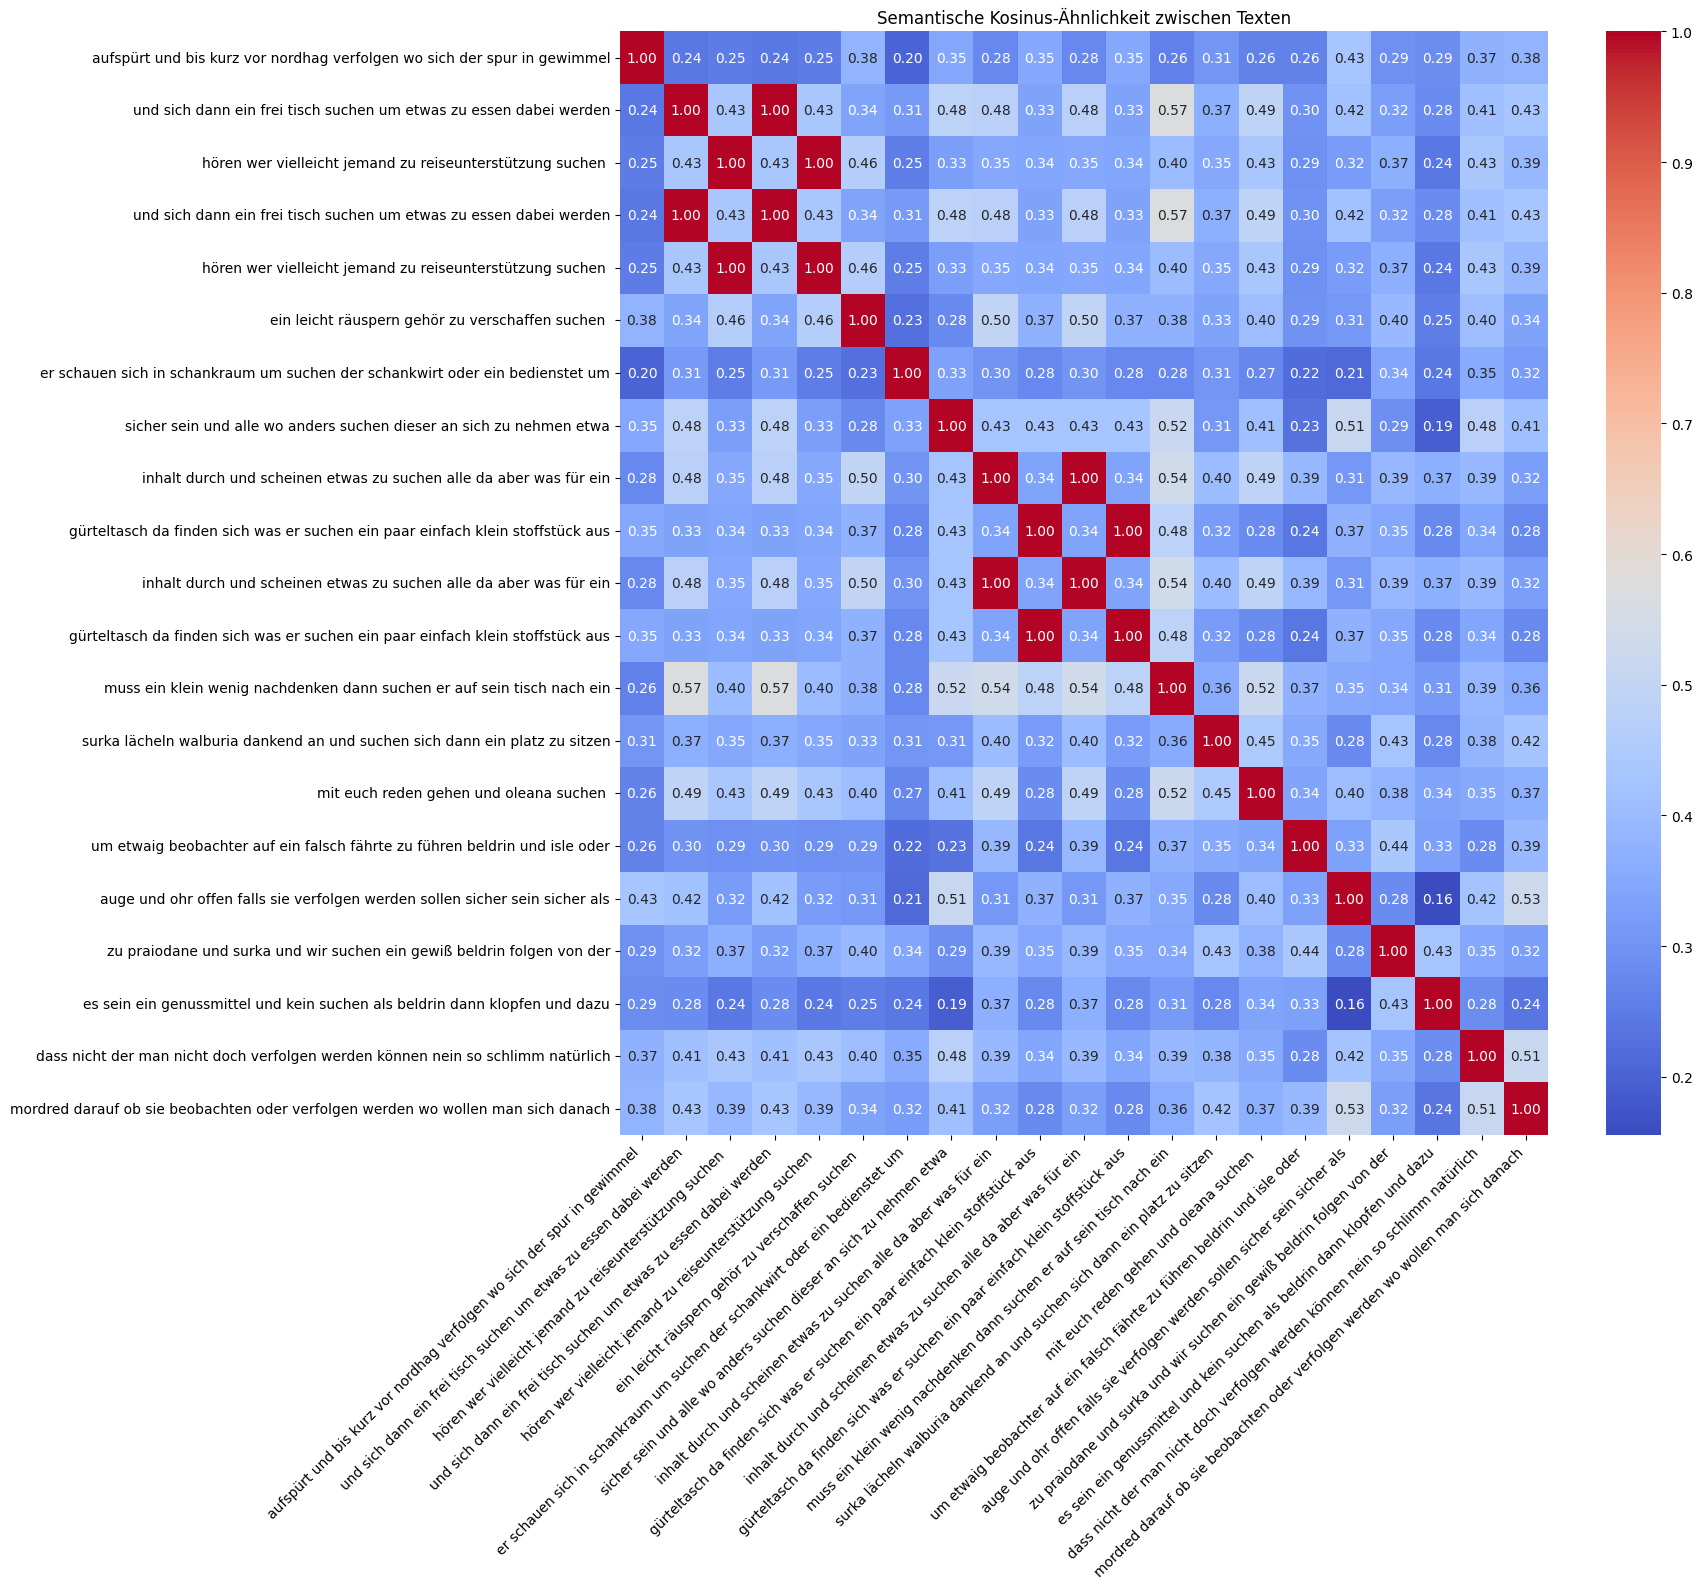

In [14]:
# Installation (falls nötig)
# pip install sentence-transformers hdbscan scikit-learn matplotlib seaborn

from sentence_transformers import SentenceTransformer, util
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Modell laden
model = SentenceTransformer('all-MiniLM-L6-v2')

#Embeddings erstellen
embeddings = model.encode(texte_verfolgung)

#HDBSCAN-Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
labels = clusterer.fit_predict(embeddings)

#Cluster-Ergebnisse ausgeben
clusters = {}
for text, label in zip(texte_verfolgung, labels):
    clusters.setdefault(label, []).append(text)

print("Cluster-Ergebnisse:")
for cluster_id, members in clusters.items():
    print(f"\nCluster {cluster_id}:")
    for member in members:
        print(f" - {member}")

#Kosinus-Ähnlichkeitsmatrix
cosine_sim = util.cos_sim(embeddings, embeddings).numpy()

#Heatmap plotten
plt.figure(figsize=(18, 16))
sns.heatmap(cosine_sim, annot=True, fmt=".2f", xticklabels=texte_verfolgung, yticklabels=texte_verfolgung, cmap="coolwarm")
plt.title("Semantische Kosinus-Ähnlichkeit zwischen Texten")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [15]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Modell laden
model = SentenceTransformer('all-MiniLM-L6-v2')

# Idee: "Verfolgung einer Person"
idea = "Eine Person wird verfolgt oder gesucht"

# Embeddings erstellen
text_embeddings = model.encode(texte_verfolgung)
idea_embedding = model.encode([idea])[0]

# Kosinus-Ähnlichkeit berechnen
cosine_scores = util.cos_sim(text_embeddings, idea_embedding).numpy().flatten()

# Ergebnisse sortieren
sorted_indices = np.argsort(-cosine_scores)  # absteigend
print("Sätze, sortiert nach Übereinstimmung mit der Idee:")
for idx in sorted_indices:
    print(f"{cosine_scores[idx]:.2f} - {texte_verfolgung[idx]}")


2025-12-17 15:39:25,920 - INFO - Use pytorch device_name: cuda:0
2025-12-17 15:39:25,922 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 1/1 [00:00<00:00, 35.45it/s]

Sätze, sortiert nach Übereinstimmung mit der Idee:
0.47 - ein leicht räuspern gehör zu verschaffen suchen 
0.42 - dass nicht der man nicht doch verfolgen werden können nein so schlimm natürlich
0.41 - mordred darauf ob sie beobachten oder verfolgen werden wo wollen man sich danach
0.38 - aufspürt und bis kurz vor nordhag verfolgen wo sich der spur in gewimmel
0.34 - zu praiodane und surka und wir suchen ein gewiß beldrin folgen von der
0.33 - hören wer vielleicht jemand zu reiseunterstützung suchen 
0.33 - hören wer vielleicht jemand zu reiseunterstützung suchen 
0.32 - auge und ohr offen falls sie verfolgen werden sollen sicher sein sicher als
0.27 - gürteltasch da finden sich was er suchen ein paar einfach klein stoffstück aus
0.27 - gürteltasch da finden sich was er suchen ein paar einfach klein stoffstück aus
0.27 - sicher sein und alle wo anders suchen dieser an sich zu nehmen etwa
0.26 - inhalt durch und scheinen etwas zu suchen alle da aber was für ein
0.26 - inhalt durch und sc

### Mehrere Ideen/Themen und jedem Satz automatisch das Thema zuordnet, zu dem er semantisch am besten passt

In [16]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Modell laden
model = SentenceTransformer('all-MiniLM-L6-v2')

# Beispiel-Sätze
texts = [
    "Der Dieb wurde von der Polizei gesucht.",
    "Heute ist das Wetter sehr schön.",
    "Jemand verfolgt mich durch die Stadt.",
    "Ich liebe Pizza.",
    "Die Polizei hat den Verdächtigen gefunden.",
    "Es regnet stark heute."
]

# Ideen/Themen
ideas = [
    "Eine Person wird verfolgt oder gesucht",   # Thema: Verfolgung
    "Schönes Wetter, Sonne oder Regen",        # Thema: Wetter
    "Essen, Mahlzeit, Lieblingsessen"          # Thema: Essen
]

# Embeddings erstellen
text_embeddings = model.encode(texts)
idea_embeddings = model.encode(ideas)

# Kosinus-Ähnlichkeit berechnen
cosine_scores = util.cos_sim(text_embeddings, idea_embeddings).numpy()

# Jeder Satz bekommt die Idee, mit der er am meisten matcht
print("Sätze und die passendste Idee:")
for i, text in enumerate(texts):
    best_idx = np.argmax(cosine_scores[i])
    print(f"{text} --> Idee: '{ideas[best_idx]}' (Score: {cosine_scores[i][best_idx]:.2f})")


2025-12-17 15:39:27,967 - INFO - Use pytorch device_name: cuda:0
2025-12-17 15:39:27,968 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 1/1 [00:00<00:00, 344.84it/s]

Sätze und die passendste Idee:
Der Dieb wurde von der Polizei gesucht. --> Idee: 'Eine Person wird verfolgt oder gesucht' (Score: 0.48)
Heute ist das Wetter sehr schön. --> Idee: 'Schönes Wetter, Sonne oder Regen' (Score: 0.58)
Jemand verfolgt mich durch die Stadt. --> Idee: 'Eine Person wird verfolgt oder gesucht' (Score: 0.46)
Ich liebe Pizza. --> Idee: 'Essen, Mahlzeit, Lieblingsessen' (Score: 0.38)
Die Polizei hat den Verdächtigen gefunden. --> Idee: 'Eine Person wird verfolgt oder gesucht' (Score: 0.49)
Es regnet stark heute. --> Idee: 'Schönes Wetter, Sonne oder Regen' (Score: 0.37)


# Exkurs Start - Was kann mittels KWIC (key-word-in-context) gemacht werden?

In [17]:
#1️⃣ Deskriptive Basisanalysen 
#1.1 Trefferzahl pro Kategorie => Welche Motive dominieren?

for cat, kwics in kwic_by_category.items():
    print(cat, len(kwics))



Reise 28
Verfolgung 21
Belohnung 28
Ausruhen 5
Ruf 3
Rettung 3
Training 3
Flucht 1
Kampf 1


In [18]:
#1.2 Treffer pro Suchwort => Welche Lexeme tragen eine Kategorie?

from collections import Counter

Counter(k["node"].lower() for k in kwic_by_category["Reise"])


Counter({'ziehen': 17, 'erreichen': 8, 'reisen': 2, 'wandern': 1})

In [19]:
#1.3 KWIC-Breite evaluieren => Reicht das Kontextfenster?

#gibt die Durchschnittslänge des linken/rechten Kontextes in Wörtern zurück
print("Durchschnitt linkes Fenster:",sum(len(k["left"].split()) for k in kwic_by_category["Reise"]) / len(kwic_by_category["Reise"]))
print("Durchschnitt rechtes Fenster:",sum(len(k["right"].split()) for k in kwic_by_category["Reise"]) / len(kwic_by_category["Reise"]))


Durchschnitt linkes Fenster: 5.214285714285714
Durchschnitt rechtes Fenster: 5.5


### Arten von Analysen, die Fenstergröße beeinflusst
**3.1 Kollokationen**
* Ziel: Wörter, die regelmäßig neben dem Suchwort stehen
* Empfehlung: kleines bis mittleres Fenster (2–5 Wörter)
* Beispiel: „auf → Reise“, „lange → Reise“

**3.2 Verb-Frames / syntaktische Rollen**
* Ziel: Subjekt, Objekt, Präpositionalobjekt erkennen
* Empfehlung: Fenster mindestens 3–6 Wörter, da Verben oft etwas entfernt stehen können
* Tipp: besser Dependency Parsing verwenden, da Fenster manchmal syntaktisch unzureichend ist

**3.3 Narrative / Diskursanalyse**
* Ziel: Handlungsmuster, zeitliche Abfolgen
* Empfehlung: größeres Fenster (6–10+ Wörter)
* Beispiel: „die Reise begann früh am Morgen und führte durch das Tal…“

### Praktische Hinweise
**4.1 Links vs. rechts**
* <u>Oft ist linker Kontext wichtiger für Subjekt / Präpositionen</u>
* <u>Rechter Kontext liefert oft Objekte oder Handlungen</u>

**4.2 Dynamische Fenster**
* Für sehr kurze Sätze → Fenster kann zu groß sein, dann endet man am Satzende
* Lösung: *max(0, start-window)* links, *min(len(tokens), end+window)* rechts

**4.3 Fenster vs. Tokenisierung**
* Je feiner tokenisiert (z. B. spaCy), desto mehr Tokens pro Wort/Punktuation
* Dann muss Fenster angepasst werden

**4.4 Fenster in der Statistik**
* Wenn du Collocations / Frequenzen berechnest, hängt das Ergebnis stark von der Fenstergröße ab
* Beispiel: Mit Fenster 2 → weniger Treffer, aber präzisere Beziehung
* Mit Fenster 6 → mehr Treffer, inkl. irrelevanter Wörter

### Rand-Notiz: Schau dir Dependency Parsing nochmal genauer an. Vllt. kommen wir auch dadurch besser weiter?

**Anwendung für deine KWICs**
1. Du nimmst den Span deines KWIC-Tokens.
2. Prüfst für jedes Token, welches Verb der Head ist.
3. Speichere das Verb + die Rolle (nsubj, dobj, pobj) → Verb-Frame.

So bekommst du saubere syntaktische Beziehungen, die unabhängig vom festen Kontextfenster sind.

In [20]:
#2️⃣ Kollokationsanalysen (klassisch für KWIC)
#2.1 Häufigste Wörter links / rechts => Typische Umfelder eines Motivs

from collections import Counter

left_words = Counter()
right_words = Counter()

for k in kwic_by_category["Reise"]:
    left_words.update(k["left"].split())
    right_words.update(k["right"].split())

print(left_words.most_common(10))
print(right_words.most_common(10))


[('der', 18), ('und', 6), ('sie', 5), ('als', 5), ('auch', 3), ('ein', 3), ('an', 3), ('in', 2), ('hier', 2), ('aus', 2)]
[('der', 9), ('sein', 8), ('und', 6), ('sie', 5), ('können', 4), ('als', 4), ('man', 4), ('zu', 3), ('sich', 3), ('noch', 3)]


In [21]:
#2.2 Positionsspezifische Kollokationen => z. B. direkt rechts vom Knoten

Counter(
    k["right"].split()[0]
    for k in kwic_by_category["Reise"]
    if k["right"]
)


Counter({'und': 4,
         'können': 2,
         'sich': 2,
         'sprechen': 2,
         'bis': 2,
         'aber': 2,
         'zu': 1,
         'wenn': 1,
         'praiodane': 1,
         'ich': 1,
         'bei': 1,
         'ihr': 1,
         'der': 1,
         'beide': 1,
         'auch': 1,
         'nicht': 1,
         'er': 1,
         'ein': 1,
         'mordred': 1,
         'unangenehm': 1})

In [22]:
#2.3 Vergleich linker vs. rechter Kontexte => syntaktische Präferenzen

left_only = left_words - right_words
right_only = right_words - left_words

right_only


Counter({'sein': 7,
         'können': 4,
         'man': 4,
         'noch': 3,
         'auf': 3,
         'aber': 3,
         'zu': 2,
         'wenn': 2,
         'haben': 2,
         'kurz': 2,
         'augenbraue': 2,
         'sprechen': 2,
         'er': 2,
         'bis': 2,
         'kurzschweren': 2,
         'kein': 2,
         'hoch': 2,
         'oben': 2,
         'vermutlich': 2,
         'immer': 2,
         'hochadlig': 2,
         'dieser': 1,
         'fremd': 1,
         'volk': 1,
         'denn': 1,
         'mal': 1,
         'norrburg': 1,
         'oberhalb': 1,
         'stadt': 1,
         'ich': 1,
         'sich': 1,
         'nie': 1,
         'verhalten': 1,
         'pferd': 1,
         'reich': 1,
         'richtung': 1,
         'ehemalig': 1,
         'sveltbund': 1,
         'womit': 1,
         'beinahe': 1,
         'überall': 1,
         'nicht': 1,
         'wahr': 1,
         'niemand': 1,
         'beide': 1,
         'wachmann': 1,
         

In [23]:
#3️⃣ Muster- & Frame-Analysen
#3.1 Häufige KWIC-Templates => Narrative Formeln

from collections import Counter

templates = Counter(
    f"{k['left'].split()[-1]} _ {k['right'].split()[0]}"
    for k in kwic_by_category["Reise"]
    if k["left"] and k["right"]
)

templates.most_common(10)


[('reichsend _ sprechen', 2),
 ('stadttor _ bis', 2),
 ('wappenrock _ aber', 2),
 ('unrat _ und', 2),
 ('salzhandel _ zu', 1),
 ('festum _ wenn', 1),
 ('rahjastunde _ praiodane', 1),
 ('phextempel _ können', 1),
 ('hierher _ ich', 1),
 ('praiodane _ bei', 1)]

In [24]:
#3.2 Verb-Frames (sehr wichtig!) => Welche Handlungen hängen am Motiv?

verbs_right = Counter()

for k in kwic_by_category["Rettung"]:
    for w in k["right"].split():
        verbs_right[w] += 1
        break

#(später mit POS-Tags präzisieren)

In [25]:
#4️⃣ Kategorien vergleichen
#4.1 Geteilte vs. exklusive Kollokationen

reise_words = Counter(
    w for k in kwic_by_category["Reise"]
    for w in k["right"].split()
)

flucht_words = Counter(
    w for k in kwic_by_category["Flucht"]
    for w in k["right"].split()
)

common = reise_words & flucht_words
distinct_reise = reise_words - flucht_words


In [31]:
#4.2 Kontrastive KWICs => Gleiches Wort, andere Kategorie

[k for k in kwic_by_category["Reise"] if k["right"] == "weg"]


[]

In [34]:
#5️⃣ Narrative & Diskursanalysen
#5.1 Vorher-Nachher-Strukturen => Ereignisabfolgen

Counter(
    tuple(k["left"].split()[-2:])
    for k in kwic_by_category["Reise"]
    if len(k["left"].split()) >= 2
)


Counter({('endich', 'reichsend'): 2,
         ('der', 'stadttor'): 2,
         ('der', 'wappenrock'): 2,
         ('voll', 'unrat'): 2,
         ('der', 'salzhandel'): 1,
         ('in', 'festum'): 1,
         ('zu', 'rahjastunde'): 1,
         ('der', 'phextempel'): 1,
         ('tulamidenlande', 'hierher'): 1,
         ('auch', 'praiodane'): 1,
         ('der', 'weg'): 1,
         ('paar', 'tag'): 1,
         ('ein', 'halborkin'): 1,
         ('offen', 'geheimnis'): 1,
         ('sonst', 'schlüsse'): 1,
         ('praiodan', 'augenbraue'): 1,
         ('auch', 'zurück'): 1,
         ('ihr', 'rätsel'): 1,
         ('beldrin', 'eintritt'): 1,
         ('ihnen', 'auftischt'): 1,
         ('der', 'hier'): 1,
         ('der', 'länge'): 1})

In [ ]:
#5.2 Rollenidentifikation => Wer handelt?

subjects = Counter(
    k["left"].split()[-1]
    for k in kwic_by_category["Training"]
)

#(später mit Dependency-Parsing verbessern)

### 6️⃣ Statistische Analysen (fortgeschritten)
##### **6.1 Schlüsselwörter pro Kategorie (Keyness)**
Was unterscheidet Motive?
* Log-Likelihood
* Chi²
* TF-IDF

##### **6.2 Clustering von KWICs**
Submotive entdecken
> TF-IDF auf left+right, dann KMeans

### 7️⃣ Visualisierung
#### **7.1 KWIC-Heatmaps**

* Kontextposition vs. Wortfrequenz

#### **7.2 Netzwerkgraphen**

* Motive ↔ Kollokationen

### 8️⃣ Best-Practice-Reihenfolge (empfohlen)

1. Trefferzahlen

2. Kollokationen links/rechts

3. Frame-Muster

4. Kategorienvergleich

5. Statistik

6. Interpretation

# Ekurs Ende

### Darstellung in Prozentualen Angaben und grafisch je Abenteuer als Gesamtprofil


 GESAMT-NARRATIV-PROFIL

Treffer gesamt:
Reise       : 24
Kampf       : 1
Ausruhen    : 5
Rettung     : 3
Flucht      : 1
Training    : 3
Verfolgung  : 17
Ruf         : 3
Belohnung   : 24

Prozentanteile gesamt:
Reise       : 29.63%
Kampf       : 1.23%
Ausruhen    : 6.17%
Rettung     : 3.7%
Flucht      : 1.23%
Training    : 3.7%
Verfolgung  : 20.99%
Ruf         : 3.7%
Belohnung   : 29.63%


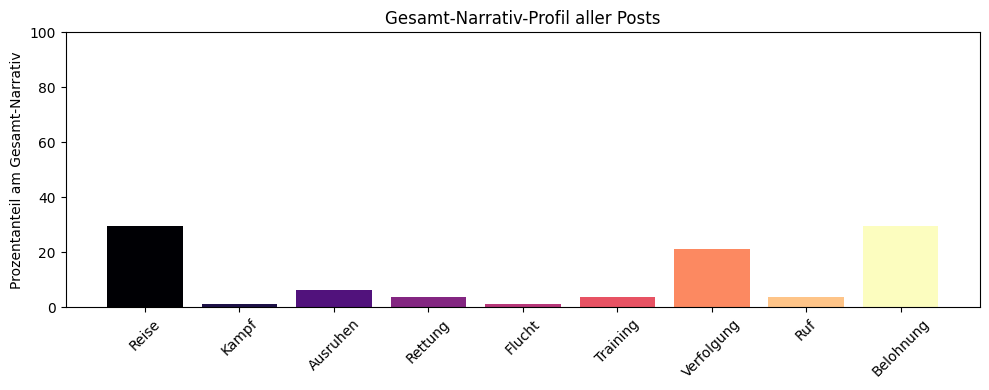

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def narrative_profile_total(posts, categories, matcher, nlp):

    # Gesamtspeicher für alle Posts
    total_hits = {c: 0 for c in categories}

    # Alle Posts durchlaufen
    for post in posts:
        doc = nlp(post)
        matches = matcher(doc)

        # Treffer im aktuellen Post
        local_hits = {c: 0 for c in categories}

        for match_id, start, end in matches:
            label = nlp.vocab.strings[match_id]
            local_hits[label] += 1

        # lokale Treffer in Gesamtzähler addieren
        for c in categories:
            total_hits[c] += local_hits[c]

    # --- Prozentanteile berechnen ---
    total = sum(total_hits.values())
    if total == 0:
        percentages = {c: 0 for c in categories}
    else:
        percentages = {
            c: round((count / total) * 100, 2)
            for c, count in total_hits.items()
        }

    # --- Ausgabe ---
    print("\n==============================")
    print(" GESAMT-NARRATIV-PROFIL")
    print("==============================\n")

    print("Treffer gesamt:")
    for c, cnt in total_hits.items():
        print(f"{c:12}: {cnt}")

    print("\nProzentanteile gesamt:")
    for c, pct in percentages.items():
        print(f"{c:12}: {pct}%")

    # --- Diagramm zeichnen ---
    plt.figure(figsize=(10, 4))
    labels = list(categories.keys())
    values = [percentages[c] for c in labels]
    colors = plt.cm.magma(np.linspace(0, 1, len(labels)))

    plt.bar(labels, values, color=colors)
    plt.title("Gesamt-Narrativ-Profil aller Posts")
    plt.ylabel("Prozentanteil am Gesamt-Narrativ")
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    return {
        "total_hits": total_hits,
        "percentages": percentages,
        "total_events": total
    }

profile = narrative_profile_total(posts, categories, matcher, nlp)


### The same aber mit Spider-Chart anstatt Balkendiagramm

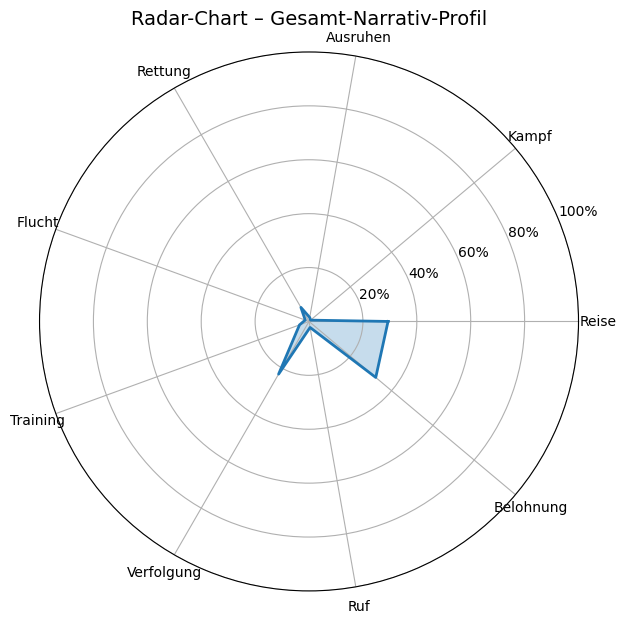

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def narrative_profile_radar(posts, categories, matcher, nlp):

    # Gesamtspeicher
    total_hits = {c: 0 for c in categories}

    # Alle Posts durchsuchen
    for post in posts:
        doc = nlp(post)
        matches = matcher(doc)

        # Treffer im Post
        local_hits = {c: 0 for c in categories}
        for match_id, start, end in matches:
            label = nlp.vocab.strings[match_id]
            local_hits[label] += 1

        # Aufaddieren
        for c in categories:
            total_hits[c] += local_hits[c]

    # Prozentwerte berechnen
    total = sum(total_hits.values())
    if total == 0:
        percentages = {c: 0 for c in categories}
    else:
        percentages = {
            c: round((cnt / total) * 100, 2) for c, cnt in total_hits.items()
        }

    # ---- RADAR-CHART ----
    labels = list(categories.keys())
    values = [percentages[c] for c in labels]

    # Radar benötigt zyklischen Anfang/Endpunkt
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    # Linien & Fläche
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)

    # Achsen
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)

    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"])
    ax.set_ylim(0, 100)

    ax.set_title("Radar-Chart – Gesamt-Narrativ-Profil", fontsize=14, pad=20)

    plt.show()

    # Rückgabe
    return {
        "total_hits": total_hits,
        "percentages": percentages,
        "total_events": total
    }

profile = narrative_profile_radar(posts, categories, matcher, nlp)


### POS-Tagging analysieren / debuggen

In [ ]:
print("---- MATCHES ----")
for match_id, start, end in matches:
    label = nlp.vocab.strings[match_id]
    span = doc[start:end]
    print(f"{label:10}  →  '{span.text}'   at {start}-{end}")

print("---- TOKENS ----")
for t in doc:
    print(f"{t.i:02d}  {t.text:12}  LEMMA={t.lemma_:12}  POS={t.pos_}")

---- MATCHES ----
---- TOKENS ----
00  @Moderatoren  LEMMA=@Moderatorum  POS=NOUN
01  :             LEMMA=--            POS=PUNCT
02  bitte         LEMMA=bitte         POS=ADV
03  hier          LEMMA=hier          POS=ADV
04  auch          LEMMA=auch          POS=ADV
05  ins           LEMMA=in            POS=ADP
06  Archiv        LEMMA=Archiv        POS=NOUN
07  verschieben   LEMMA=verschieben   POS=VERB
08  !             LEMMA=--            POS=PUNCT
09                LEMMA=              POS=SPACE
10  Alle          LEMMA=aller         POS=DET
11  Zeiten        LEMMA=Zeit          POS=NOUN
12  sind          LEMMA=sein          POS=AUX
13  UTC+02:00     LEMMA=UTC+02:00     POS=NOUN
14  Seite         LEMMA=Seite         POS=NOUN
15  12            LEMMA=12            POS=NUM
16                LEMMA=              POS=SPACE
17  von           LEMMA=von           POS=ADP
18  12            LEMMA=12            POS=NUM


# Narratologie

# Narratologische Gliederung einer epischen Geschichte

Es gibt mehrere etablierte Modelle in der Narratologie, mit denen man eine **epische Geschichte** systematisch strukturieren kann. Je nach Theorieansatz unterscheiden sich die Begriffe etwas, aber im Kern geht es immer um die **innere Struktur** (Handlungsaufbau) und die **erzählerische Darstellung** (wie erzählt wird).

---

## 1. Klassischer Handlungsaufbau (Dramaturgie der Epik)
Der klassische fünfteilige Aufbau (u. a. nach Gustav Freytag) lässt sich auch auf epische Texte übertragen:

1. **Exposition**  
   Einführung in Figuren, Raum, Zeit, Ausgangssituation, zentrale Konflikte.

2. **Steigende Handlung mit erregendem Moment**  
   Probleme spitzen sich zu; erste Wendung; Konflikt gewinnt an Dynamik.

3. **Höhepunkt / Peripetie**  
   Der entscheidende Wendepunkt der Handlung; die größte Spannung.

4. **Fallende Handlung mit retardierendem Moment**  
   Konflikte lösen sich, aber es kann Verzögerungen/Komplikationen geben.

5. **Katastrophe oder Lösung (Dénouement)**  
   Finale Klärung; tragisches oder versöhnliches Ende.

## 2. Narratologische Grundkomponenten einer Erzählung
Diese Einteilung gehört zur strukturalen Narratologie (z. B. Gérard Genette, Stanzel):

### A. Geschichte (Story / Histoire)
Inhaltsebene: **Was** passiert?

- Ereignisse / Plot  
- Figurenkonstellation (Protagonist, Antagonist, Nebenfiguren)  
- Handlungslogik / Kausalitäten  
- Settings (Ort, Zeit)  
- Motiv- und Themenstruktur  

### B. Diskurs (Discourse / Discours)
Darstellungsebene: **Wie** wird erzählt?

- **Erzählzeit vs. erzählte Zeit**  
- **Ordnung (Anachronien)**: Rückblenden (Analepse), Vorausdeutungen (Prolepse)  
- **Erzählperspektive / Fokalisierung**  
  - Ich-Erzähler  
  - Personaler Erzähler  
  - Auktorialer Erzähler  
- **Erzählverhalten**  
  - berichtend  
  - kommentierend  
  - reflektierend  
- **Darstellungsformen**  
  - Erzählerbericht  
  - direkte / indirekte Rede  
  - erlebte Rede  
  - innerer Monolog  

### C. Zeitgestaltung
- Zeitdeckung, Zeitraffung, Zeitdehnung  
- Reihenfolge  
- Dauer  


## 3. Moderne Modelle der Erzählstruktur

### A. Heldenreise (Monomythos nach Campbell/Vogler)
Typische Stationen:

1. Gewohnte Welt  
2. Ruf zum Abenteuer  
3. Verweigerung / Mentor  
4. Überschreiten der Schwelle  
5. Prüfungen, Verbündete, Feinde  
6. Tiefste Höhle / Krise  
7. Entscheidung / Wiedergeburt  
8. Rückkehr mit dem „Elixier“

### B. Dreiaktstruktur
- **Akt 1: Setup**  
  Figuren, Welt, Konflikt  
- **Akt 2: Konfrontation**  
  steigende Komplikationen, Midpoint  
- **Akt 3: Auflösung**  
  Showdown und neue Ordnung  

### C. Propp’sche Funktionen (bei Märchen)
31 mögliche Handlungsschritte (z. B. Verbot, Aufgabe, Kampf, Heimkehr). Geeignet für traditionelle epische Erzählformen.


## 4. Elemente der epischen Darstellung
Für eine epische Geschichte typisch:

- Allwissender Erzähler (häufig, aber nicht zwingend)  
- Beschreibung von Raum und Zeit  
- Breite Schilderungen  
- Szenisch-episodische Struktur  
- Dialoge und Innensicht  

## 5. Kurzfassung: Wichtigste Abschnitte

1. Exposition  
2. Konfliktentwicklung  
3. Höhepunkt  
4. Krise / Wendepunkt  
5. Lösung / Finale  
6. Erzählinstanz (Wer erzählt?)  
7. Erzählperspektive (Wie wird wahrgenommen?)  
8. Zeitgestaltung (Wann, wie schnell?)  
9. Darstellungsformen (Wie wird erzählt?)  

# Planungs- und Analysehilfe für epische Geschichten

| Abschnitt / Element                | Analysefragen / Beobachtungspunkte                                 | Planungsnotizen / Ideen |
|-----------------------------------|--------------------------------------------------------------------|------------------------|
| **Exposition**                     | Wer sind die Hauptfiguren? Wo und wann spielt die Geschichte? Was ist der Ausgangszustand? | Einführung der Figuren und Welt, Konflikte andeuten |
| **Konfliktentwicklung / steigende Handlung** | Welche Probleme oder Herausforderungen treten auf? Wie entwickeln sich Beziehungen? | Konflikte planen, Spannung aufbauen |
| **Höhepunkt / Peripetie**          | Wann erreicht die Handlung den dramatischsten Punkt? Wer oder was entscheidet? | Wendepunkt gestalten, Spannung maximieren |
| **Fallende Handlung / retardierendes Moment** | Welche Folgen hat der Höhepunkt? Gibt es weitere Komplikationen? | Übergang zur Lösung vorbereiten, Konflikte reduzieren |
| **Lösung / Dénouement**            | Wie werden Konflikte gelöst? Welches Ende ist angedacht (tragisch, versöhnlich, offen)? | Abschluss planen, Themen reflektieren |
| **Erzählinstanz**                  | Wer erzählt die Geschichte? Ist der Erzähler zuverlässig? | Erzählerrolle wählen: Ich / auktorial / personal |
| **Erzählperspektive / Fokalisierung** | Durch wessen Augen sehen wir die Handlung? Ist die Sicht konstant oder wechselnd? | Perspektivwechsel planen, Innensicht einbeziehen |
| **Zeitgestaltung**                 | Wie verläuft die Zeit? Gibt es Rückblenden oder Vorausdeutungen? | Reihenfolge, Dauer, Zeitraffung / Zeitdehnung planen |
| **Darstellungsformen**             | Welche Erzähltechniken werden genutzt? (Bericht, direkte Rede, innerer Monolog) | Mischung aus Erzählerbericht, Dialogen, Monologen planen |
| **Themen / Motive / Symbolik**     | Welche zentralen Ideen oder Symbole tauchen auf? | Leitmotive oder wiederkehrende Themen entwickeln |


----------------------------

----------------------------------------

# Elemente einer Geschichte

Es gibt viele mögliche **Abschnitte bzw. Bausteine einer Geschichte**, je nach Modell (z. B. Heldenreise, Drei-Akt-Struktur, Kishōtenketsu).  
Hier ist eine **umfangreiche Liste typischer Elemente**, die über „Reise“, „Konflikt“, „Rasten“ usw. hinausgehen.

---

## ⭐ Grundlegende erzählerische Elemente
- **Einführung / Exposition** – Vorstellung von Welt, Figuren, Status quo  
- **Auslösendes Ereignis** – der Moment, der alles in Gang setzt  
- **Steigende Handlung** – zunehmende Komplikationen  
- **Höhepunkt** – zentraler Wendepunkt oder größter Konflikt  
- **Fallende Handlung** – Aufräumen der Konsequenzen  
- **Auflösung / Denouement** – Abschluss, neuer Zustand

---

## ⭐ Elemente der Heldenreise (Joseph Campbell u. a.)
- **Ruf zum Abenteuer**  
- **Zögern / Weigerung**  
- **Mentor / Hilfe**  
- **Überschreiten der Schwelle**  
- **Prüfungen, Verbündete, Feinde**  
- **Annäherung an die tiefste Höhle**  
- **Ordeal / entscheidende Krise**  
- **Belohnung / Erkenntnis**  
- **Rückweg**  
- **Wiedergeburt / Transformation**  
- **Rückkehr mit dem Elixier**

---

## ⭐ Drei- oder Fünf-Akt-Struktur
- **Akt 1: Setup**  
  - Setting, Figuren, Problem  
- **Akt 2: Konfrontation**  
  - Komplikationen, Scheitern, Wendepunkte  
- **Akt 3: Auflösung**  
  - Entscheidung, Finale, neues Gleichgewicht  

Erweiterte 5-Akt-Variante: **Einführung – Steigerung – Höhepunkt – Retardation – Schluss**

---

## ⭐ Plot-Bausteine / narrative Funktionen
- **Foreshadowing** – Vorahnung  
- **Rote Heringe** – falsche Fährten  
- **Midpoint-Reversal** – große Wendung in der Mitte  
- **Enthüllung / Revelation**  
- **Konflikte**: intern, extern, zwischen Figuren, gegen Natur, System, sich selbst  
- **Subplots** – Nebenhandlungen  
- **Cliffhanger** – offener Spannungspunkt  
- **Twist** – überraschende Wendung  
- **Rückblende (Flashback)**  
- **Vorausdeutung (Flashforward)**  
- **Montage / Zusammenfassender Ablauf**  
- **Worldbuilding-Abschnitt**  
- **Beziehungsentwicklung**  
- **Moralisches Dilemma**

---

## ⭐ Japanische Struktur Kishōtenketsu
- **Ki – Einführung**  
- **Shō – Entwicklung**  
- **Ten – Twist / Kontrast**  
- **Ketsu – Auflösung**

---

## ⭐ Charakterbezogene Abschnitte
- **Vorstellung der Motivation**  
- **Charakterbogen / persönliche Entwicklung**  
- **Innerer Konflikt**  
- **Moment der Krise**  
- **Selbstoffenbarung / Epiphanie**  
- **Transformation**

---

## ⭐ Thematische oder atmosphärische Bausteine
- **Stimmungswechsel**  
- **Ruhige Szene („Rasten“)**  
- **Spannungsaufbau / Suspense**  
- **Humor / Comic Relief**  
- **Symbolische Szenen**  
- **Moralische oder philosophische Reflexion**

---

## ⭐ Action- und Abenteuer-spezifische Elemente
- **Training / Vorbereitung**  
- **Verfolgungsjagd**  
- **Kampf / Auseinandersetzung**  
- **Flucht**  
- **Entdeckung / Exploration**  
- **Rettung / Opfermoment**

---

> Optional: Man kann diese Elemente je nach Genre kombinieren, zu einer eigenen Story-Struktur zusammenfassen oder als Vorlage für das Schreiben verwenden.


| Element / Abschnitt              | Beschreibung                                           | Funktion / Wirkung                                     |
|---------------------------------|-------------------------------------------------------|-------------------------------------------------------|
| Einführung / Exposition          | Vorstellung von Welt, Figuren, Status quo            | Leser ins Setting einführen, Grundstimmung setzen    |
| Auslösendes Ereignis             | Ereignis, das Handlung in Gang setzt                  | Startpunkt der Geschichte, Motivation für Figuren   |
| Steigende Handlung               | Zunehmende Komplikationen                             | Spannung aufbauen, Konflikte entwickeln              |
| Höhepunkt                        | Zentraler Wendepunkt oder größter Konflikt           | Dramatischer Höhepunkt, emotionale Intensität       |
| Fallende Handlung                | Konsequenzen des Höhepunkts                           | Spannung abbauen, Konflikte lösen                    |
| Auflösung / Denouement           | Abschluss der Handlung                                 | Neuen Zustand zeigen, offene Fragen beantworten     |
| Ruf zum Abenteuer                | Figur wird zu Handlung motiviert                      | Beginn der Heldenreise                               |
| Mentor / Hilfe                   | Unterstützende Figur                                  | Figur erhält Rat, Hilfe oder Ressourcen             |
| Prüfungen / Verbündete / Feinde  | Hindernisse und Begegnungen                           | Charakterentwicklung, Spannung                       |
| Rückweg / Rückkehr mit Elixier   | Rückkehr zur Ausgangswelt mit Erfahrung/Belohnung    | Transformation der Figur zeigen                      |
| Foreshadowing / Vorausdeutung    | Hinweise auf spätere Ereignisse                       | Spannung aufbauen, Leser vorbereiten                 |
| Rote Heringe                     | Ablenkungen / falsche Hinweise                        | Überraschungseffekt, Twists                           |
| Midpoint-Reversal                | Wendepunkt in der Mitte der Geschichte               | Dramatische Kehrtwende, neue Richtung                |
| Subplot / Nebenhandlung          | parallele Geschichten                                 | Tiefe und Komplexität der Story erhöhen             |
| Cliffhanger                      | Offenes Ende einer Szene                               | Spannung steigern, Leser neugierig machen           |
| Twist / überraschende Wendung    | Unerwartete Entwicklung                               | Überraschung, Aufmerksamkeit halten                  |
| Rückblende / Flashback           | Szenen aus der Vergangenheit                          | Hintergrundinformationen, Motivation erklären       |
| Charakterbogen / Entwicklung     | Veränderung der Figur im Verlauf                       | Persönliche Transformation sichtbar machen           |
| Innerer Konflikt                 | Konflikt innerhalb der Figur                           | Tiefe, emotionale Komplexität                        |
| Ruhe / Rasten                     | Entspannung oder Pause in der Handlung               | Tempo steuern, Leser verschnaufen lassen            |
| Stimmungswechsel                 | Änderung von Atmosphäre oder Ton                      | Emotionale Wirkung verstärken                        |
| Training / Vorbereitung           | Figur übt Fähigkeiten oder bereitet sich vor         | Realistische Entwicklung, Spannung aufbauen         |
| Kampf / Konfrontation             | Auseinandersetzungen                                   | Action, Konfliktlösung                               |
| Entdeckung / Exploration          | Figur erkundet neue Orte oder Geheimnisse            | Neugier wecken, Story vorantreiben                   |


-----------

--------------

# Typische Verben und Nomen für Fantasy-Narrativ-Situationen

| Kategorie                  | Typische Verben                               | Typische Nomen                        |
|----------------------------|----------------------------------------------|--------------------------------------|
| **Reise / Aufbruch**       | reisen, wandern, ziehen, marschieren, aufbrechen | Reise, Weg, Pfad, Expedition, Marsch |
| **Kampf / Konflikt**       | kämpfen, angreifen, verteidigen, zuschlagen, stechen | Kampf, Angriff, Duell, Schlacht, Gegner, Feind |
| **Ausruhen / Erholung**    | ausruhen, rasten, schlafen, lagern, entspannen | Rast, Pause, Lager, Ruhe, Erholung |
| **Rettung / Opfer**        | retten, befreien, beschützen, opfern         | Rettung, Opfer, Heldentat, Gefahr, Bedrohung |
| **Flucht / Entkommen**     | fliehen, entkommen, wegrennen, flüchten, verstecken | Flucht, Unterschlupf, Versteck, Panik |
| **Training / Vorbereitung**| trainieren, üben, vorbereiten, meditieren    | Training, Übung, Vorbereitung, Lektion, Technik |
| **Verfolgung / Jagd**      | verfolgen, jagen, suchen, aufspüren          | Verfolgung, Jagd, Spur, Fährte |
| **Ruf zum Abenteuer**      | rufen, einladen, beauftragen, verkünden, offenbaren | Ruf, Auftrag, Prophezeiung, Vision, Botschaft |
| **Belohnung / Erkenntnis** | belohnen, erkennen, verstehen, entdecken, gewinnen | Belohnung, Schatz, Erkenntnis, Wahrheit, Einsicht |
